In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import zipfile
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib

In [20]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),os.path.relpath(os.path.join(root, file), os.path.join(path, '..')))

In [49]:
baseDir = r'C:\Users\Hoek\Downloads\reizenExport 2017-03-20 08.18.10'

# data files
file_dumping = os.path.join(baseDir, r'data', r'reizen_dumping.csv')
file_loading = os.path.join(baseDir, r'data', r'reizen_loading.csv')
file_stats= os.path.join(baseDir, r'data', r'stats_reizen.csv')
file_reizen_plot = os.path.join(baseDir, r'data', r'stats_reizen.png')

# load csv into dataframes
df_d = pd.read_csv(file_dumping, na_values=-9999.0)
df_l = pd.read_csv(file_loading, na_values=-9999.0)

# apply a union join 
df_dl = pd.concat((df_d,df_l))# pd.merge(df_l,df_d, how='right', on='Datum')

# set Datum as index and force to datetime
df_dl.set_index('Datum', inplace=True)
df_dl.index = pd.to_datetime(df_dl.index)

# combine stats from dagrapport and mars, where currently mars stats is commented out
df_dl['Kuubs gebaggerd (m3)'] = df_dl['Kuubs gebaggerd (m3 dagrapport)'] #+ df_dl['Kuubs gebaggerd (m3 mars)']
df_dl['Kuubs verspreid (m3)'] = df_dl['Kuubs verspreid (m3 dagrapport)'] #+ df_dl['Kuubs verspreid (m3 mars)']
df_dl['Kuubs zand winning (m3)'] = df_dl['Kuubs zand winning (m3 dagrapport)']
df_dl = df_dl[['Kuubs gebaggerd (m3)','Kuubs verspreid (m3)','Kuubs zand winning (m3)']]

# drop rows where all data columns contain NoData 
df_dl_drop = df_dl.dropna(how='all', subset=['Kuubs gebaggerd (m3)',
                                             'Kuubs zand winning (m3)', 
                                             #'Kuubs gebaggerd (m3 mars)',
                                             'Kuubs verspreid (m3)',
                                             #'Kuubs verspreid (m3 mars)'
                                            ])




# groupby year, month and week using a summation and save to csv
stats = df_dl.groupby([df_dl.index.year,df_dl.index.month,df_dl.index.week]).sum()
#stats.to_csv(file_stats)

# resample to week and month as input for a plot
df_daily_sum = df_dl_drop.groupby(df_dl_drop.index).sum()
df_ts_W = df_daily_sum.resample('W').sum()
df_ts_M = df_daily_sum.resample('M').sum()

In [50]:
# first 5 rows of joined pandas dataframe on day level by loading and dumping locations
# m3 dagrapport is gemeten bij vdLee
# m3 MARS is gemeten door RWS MARS systeem
# waarbij vdLee aangeeft dat op dit moment alleen de vdLee registraties leidend zijn.
df_dl.head()

,Kuubs gebaggerd (m3),Kuubs verspreid (m3),Kuubs zand winning (m3)
Datum,,,
2016-09-21,NaN,NaN,NaN
2016-09-21,NaN,NaN,NaN
2016-09-21,NaN,NaN,NaN
2016-09-21,NaN,NaN,NaN
2016-09-21,NaN,NaN,NaN


In [51]:
# create multi index using year - month - and week levels
stats.tail(9)

Kuubs gebaggerd (m3)  Kuubs verspreid (m3)  Kuubs zand winning (m3)
2017 2 5               31290.48              32040.48                   4443.0
       6               42816.72              42066.72                   2343.0
       7               33841.58              31636.58                    223.0
       8               15621.00              15621.00                   3044.0
       9                1500.00               1500.00                    680.0
     3 9               12849.00              12849.00                   2263.0
       10              13653.00              13653.00                   3628.0
       11                   NaN                   NaN                      NaN
       12                   NaN                   NaN                      NaN

In [52]:
# plot the week and day level combined of vdLee data and MARS data

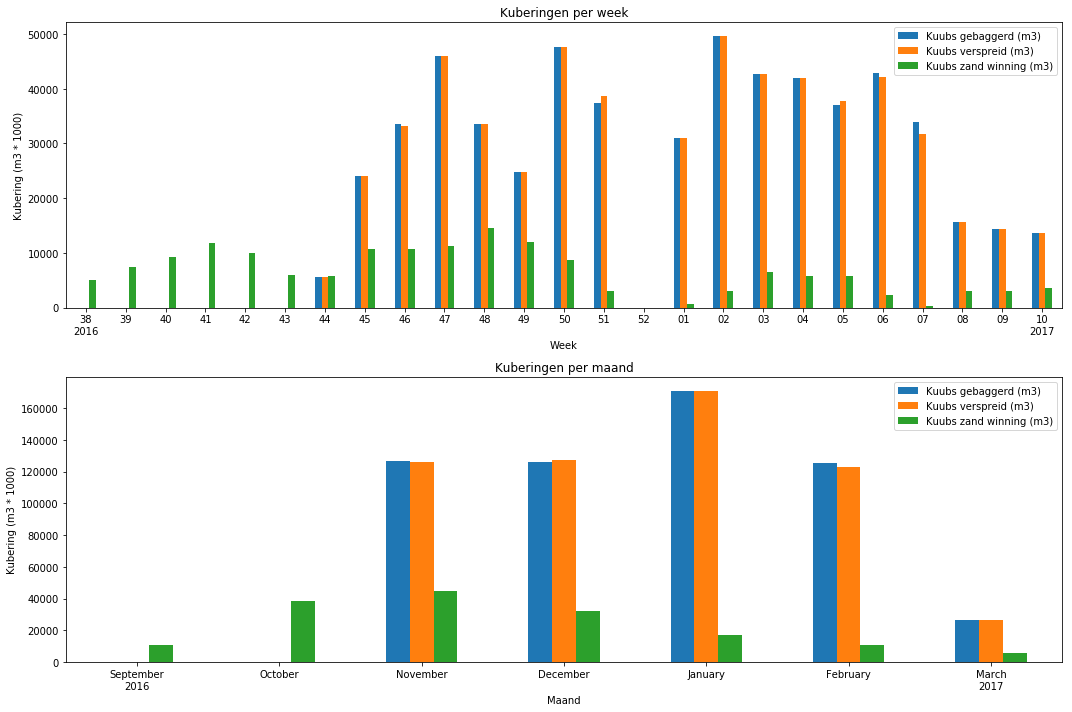

In [56]:
# week plot
plt.subplot(211)
ax = df_ts_W.plot(kind='bar', x=df_ts_W.index, stacked=False, figsize=(15,10), ax=plt.gca())
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(df_ts_W.index)
# weeknumber as tick
ticklabels[::1] = [item.strftime('%W') for item in df_ts_W.index[::1]]
ticklabels= ['52' if x=='00' else x for x in ticklabels]
# show year for first and last item
ticklabels[::len(df_ts_W.index)-1] = [item.strftime('%W\n%Y') for item in df_ts_W.index[::len(df_ts_W.index)-1]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Kubering (m3 * 1000)')
ax.set_xlabel('Week')
ax.set_title('Kuberingen per week')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)

# month plot
plt.subplot(212)
ax = df_ts_M.plot(kind='bar', x=df_ts_M.index, stacked=False, figsize=(15,10), ax=plt.gca())
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(df_ts_M.index)
# month name as tick
ticklabels[::1] = [item.strftime('%B') for item in df_ts_M.index[::1]]
ticklabels= ['52' if x=='00' else x for x in ticklabels]
# show year for first and last item
ticklabels[::len(df_ts_M.index)-1] = [item.strftime('%B\n%Y') for item in df_ts_M.index[::len(df_ts_M.index)-1]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Kubering (m3 * 1000)')
ax.set_xlabel('Maand')
ax.set_title('Kuberingen per maand')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)

# tight it all together and save

plt.tight_layout()
plt.show()

In [29]:
# if required zip the stats dataframe and plot as csv files

In [30]:
# zip names
fileName = 'reizenExport '+datetime.now().strftime('%Y-%m-%d %H.%M.%S')+'.zip'

zipFile = os.path.join(baseDir, r'zipped',fileName)
folder2zip = os.path.join(baseDir,r'data')
print ('zilfilename:',zipFile)
print ('folderzipfile:', folder2zip)

zilfilename: C:\Users\Hoek\Downloads\reizenExport 2017-03-20 08.18.10\zipped\reizenExport 2017-03-27 09.47.51.zip
folderzipfile: C:\Users\Hoek\Downloads\reizenExport 2017-03-20 08.18.10\data


In [ ]:
# zip data files to zip folder
zipf = zipfile.ZipFile(zipFile, 'w', zipfile.ZIP_DEFLATED)
zipdir(folder2zip, zipf)
zipf.close()